In [ ]:
!pip install numpy tensorflow scikit-learn matplotlib requests


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


: 

In [ ]:
import numpy as np
import tensorflow as tf
import re
import requests
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Masking
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# --- Configuration ---
# This is the 'n' in "n words as features"
SEQUENCE_LEN = 10 
EMBEDDING_DIM = 100
GLOVE_FILE = 'glove.6B/glove.6B.100d.txt'
DATA_URL = 'https://www.gutenberg.org/files/11/11-0.txt'
DATA_FILE = 'alice_in_wonderland.txt'

# Problem Statement

This project aims to demonstrate the application of Recurrent Neural Networks (RNNs) in sequential learning and text forecasting. The primary goal is to build, train, and evaluate a Long Short-Term Memory (LSTM) model capable of predicting the next word in a given sequence of text. The model will be trained on the text of "Alice's Adventures in Wonderland" and will leverage 100-dimensional GloVe pretrained word embeddings to understand semantic relationships between words. The final deliverable will be a comprehensive report and a trained model that can complete sentences by sequentially predicting the most probable next word.

 # Algorithm of the Solution
(data preparation and model-building)

## 1. Identify and Prepare the Dataset

First, we'll download the text of "Alice's Adventures in Wonderland" and perform the required preprocessing.

In [ ]:
# --- 1. Download and Prepare Data ---

# Download the dataset
try:
    with open(DATA_FILE, 'r', encoding='utf-8') as f:
        text = f.read()
    print(f"Loaded data from local file '{DATA_FILE}'.")
except FileNotFoundError:
    print(f"Downloading data from '{DATA_URL}'...")
    response = requests.get(DATA_URL)
    response.encoding = 'utf-8' # Ensure correct encoding
    text = response.text
    with open(DATA_FILE, 'w', encoding='utf-8') as f:
        f.write(text)
    print(f"Data saved to '{DATA_FILE}'.")

# Clean the text: Find the start and end of the actual story
start_marker = "*** START OF THIS PROJECT GUTENBERG EBOOK ALICE'S ADVENTURES IN WONDERLAND ***"
end_marker = "*** END OF THIS PROJECT GUTENBERG EBOOK ALICE'S ADVENTURES IN WONDERLAND ***"
start_index = text.find(start_marker)
end_index = text.find(end_marker)

if start_index != -1 and end_index != -1:
    text = text[start_index + len(start_marker) : end_index]
    print("Extracted main content of the book.")

# Preprocessing steps from assignment:
def clean_text(text):
    text = text.lower() # Convert to lowercase
    text = re.sub(r'[^a-z\s]', '', text) # Remove punctuation and numbers
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace
    return text

cleaned_text = clean_text(text)
words = cleaned_text.split(' ') # Split strings into lists of individual words
print(f"Total words in corpus: {len(words)}")

NameError: name 'DATA_FILE' is not defined

In [ ]:
# --- 2. Tokenization ---

tokenizer = Tokenizer()
tokenizer.fit_on_texts([cleaned_text]) # Note: [cleaned_text] because fit_on_texts expects a list of documents
vocab_size = len(tokenizer.word_index) + 1 # +1 for the 0-index (padding)

print(f"Vocabulary size: {vocab_size}")

# Save the tokenizer for the Streamlit app
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

Vocabulary size: 2763


In [ ]:
# --- 3. Create Sequences ---

# Convert the entire corpus into a sequence of integers
all_sequences = tokenizer.texts_to_sequences([cleaned_text])[0]

X = []
y = []

# We set the number of words as a parameter (SEQUENCE_LEN)
# We use words 1 through n as features and the n+1 word as the label
for i in range(SEQUENCE_LEN, len(all_sequences)):
    # Features: words from i-SEQUENCE_LEN to i-1
    X.append(all_sequences[i-SEQUENCE_LEN : i])
    # Label: word at index i
    y.append(all_sequences[i])

X = np.array(X)
y = np.array(y)

# One-hot encode the labels (y)
# This is necessary for 'categorical_crossentropy' loss
y = to_categorical(y, num_classes=vocab_size)

print(f"Number of sequences (samples): {len(X)}")
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Save sequence length for the app
with open('sequence_len.pkl', 'wb') as f:
    pickle.dump(SEQUENCE_LEN, f)

Number of sequences (samples): 26466
Shape of X: (26466, 10)
Shape of y: (26466, 2763)


In [ ]:
# --- 4. Load GloVe Embeddings ---

embeddings_index = {}
try:
    with open(GLOVE_FILE, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f"Found {len(embeddings_index)} word vectors in '{GLOVE_FILE}'.")
except FileNotFoundError:
    print(f"Error: GloVe file not found at '{GLOVE_FILE}'.")
    print("Please download 'glove.6B.zip', unzip it, and place 'glove.6B.100d.txt' in a 'glove.6B' folder.")
    # You would stop execution here in a real script

# Create an embedding matrix for our vocabulary
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words found in embedding index will be non-zero
        embedding_matrix[i] = embedding_vector
    # Words not found in embedding index will be all-zeros (as required)

print(f"Embedding Matrix shape: {embedding_matrix.shape}")

Found 400000 word vectors in 'glove.6B/glove.6B.100d.txt'.
Embedding Matrix shape: (2763, 100)


In [ ]:
# --- 5. Explore Embeddings ---

def find_similar_words(word, top_n=5):
    if word not in tokenizer.word_index:
        print(f"'{word}' is not in the vocabulary.")
        return
    
    word_idx = tokenizer.word_index[word]
    word_vec = embedding_matrix[word_idx].reshape(1, -1)
    
    if np.all(word_vec == 0):
        print(f"'{word}' has no pretrained GloVe embedding (vector is all zeros).")
        return

    # Calculate cosine similarity against all words
    similarities = cosine_similarity(word_vec, embedding_matrix)
    
    # Get top_n similar indices (most similar is itself, so skip index 0)
    # We add 1 to top_n to account for the word itself
    similar_indices = similarities[0].argsort()[-(top_n+1):][::-1]
    
    print(f"Words most similar to '{word}':")
    for idx in similar_indices:
        if idx == 0 or idx == word_idx: # Skip padding token and the word itself
            continue
        print(f"- {tokenizer.index_word[idx]} (Similarity: {similarities[0][idx]:.4f})")

find_similar_words('alice')
find_similar_words('rabbit')
find_similar_words('queen')

Words most similar to 'alice':
- ann (Similarity: 0.6903)
- mary (Similarity: 0.6868)
- sister (Similarity: 0.6420)
- daughter (Similarity: 0.6292)
- lady (Similarity: 0.5852)
Words most similar to 'rabbit':
- cat (Similarity: 0.7424)
- mouse (Similarity: 0.6907)
- duck (Similarity: 0.6892)
- pig (Similarity: 0.6474)
- dog (Similarity: 0.6469)
Words most similar to 'queen':
- king (Similarity: 0.7508)
- royal (Similarity: 0.7065)
- lady (Similarity: 0.7045)
- crown (Similarity: 0.6681)
- majesty (Similarity: 0.6484)


In [ ]:
# --- 6. Build the LSTM Model ---

model = Sequential()

# An Embedding layer
# We use 'weights' to load pretrained GloVe embeddings
# We set 'trainable=False' so they are not updated during training
# We set 'mask_zero=True' which is a more efficient way to handle masking
model.add(Embedding(
    input_dim=vocab_size,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=SEQUENCE_LEN,
    trainable=False,
    mask_zero=True  # This tells subsequent layers to ignore 0-padded inputs
))

# Note: The prompt mentions a `Masking` layer. `mask_zero=True` in the
# Embedding layer is the modern, preferred way. If you *must* use the
# specific layer, you would set `mask_zero=False` above and add this:
# model.add(Masking(mask_value=0.0))

# The heart of the network: a layer of LSTM cells
model.add(LSTM(
    units=150, 
    dropout=0.2,       # Dropout for input/recurrent connections
    recurrent_dropout=0.2 
    # 'return_sequences=False' is the default, which is correct for a
    # many-to-one architecture with a single LSTM layer.
))

# A fully connected Dense layer with relu
model.add(Dense(units=256, activation='relu'))

# A Dropout layer
model.add(Dropout(0.5))

# A Dense fully connected output layer
model.add(Dense(units=vocab_size, activation='softmax'))

# Compile the model with the Adam optimizer
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/Users/wyattlindseth/GCU/CST-435/CST-435-RNN/venv/lib/python3.13/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       276,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 276,300 (1.05 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 276,300 (1.05 MB)

In [ ]:
# --- 7. Train the Model ---

# Define callbacks
# Model Checkpoint: saves the best model
checkpoint = ModelCheckpoint(
    'best_model.keras',        # Save as .keras (modern format)
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

# Early Stopping: halts training when validation loss stops decreasing
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=1,
    mode='max',
    restore_best_weights=True # Restore weights from the best epoch
)

# Note: Training may take a considerable amount of time.
# For a faster (but less accurate) result, reduce the epochs
# or use a subset of the data.
print("Starting model training...")
history = model.fit(
    X,
    y,
    epochs=100,  # Set high, EarlyStopping will handle it
    batch_size=128,
    validation_split=0.2, # Use 20% of data for validation
    callbacks=[checkpoint, early_stopping]
)
print("Model training complete.")

Starting model training...
Epoch 1/100
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0442 - loss: 6.6937
Epoch 1: val_accuracy improved from None to 0.08462, saving model to best_model.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.0504 - loss: 6.3249 - val_accuracy: 0.0846 - val_loss: 6.1612
Epoch 2/100
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0552 - loss: 6.0163
Epoch 2: val_accuracy improved from 0.08462 to 0.09067, saving model to best_model.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.0594 - loss: 5.9849 - val_accuracy: 0.0907 - val_loss: 6.0712
Epoch 3/100
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0716 - loss: 5.8089
Epoch 3: val_accuracy improved from 0.09067 to 0.09312, saving model to best_model.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.0716 - loss: 5.8167 - val_accuracy: 0.0931 - val_loss: 5.9580
Epoch 4/100
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0812 - loss: 5.6429
Epo

In [ ]:
from tensorflow.keras.models import load_model

# Load the model you already trained
# (Make sure 'best_model.keras' is in the same folder as your notebook)
model = load_model('best_model.keras') 

# Re-save it in the HDF5 format
model.save('best_model.h5') 

print("Model successfully re-saved as best_model.h5")

Plotting training history...


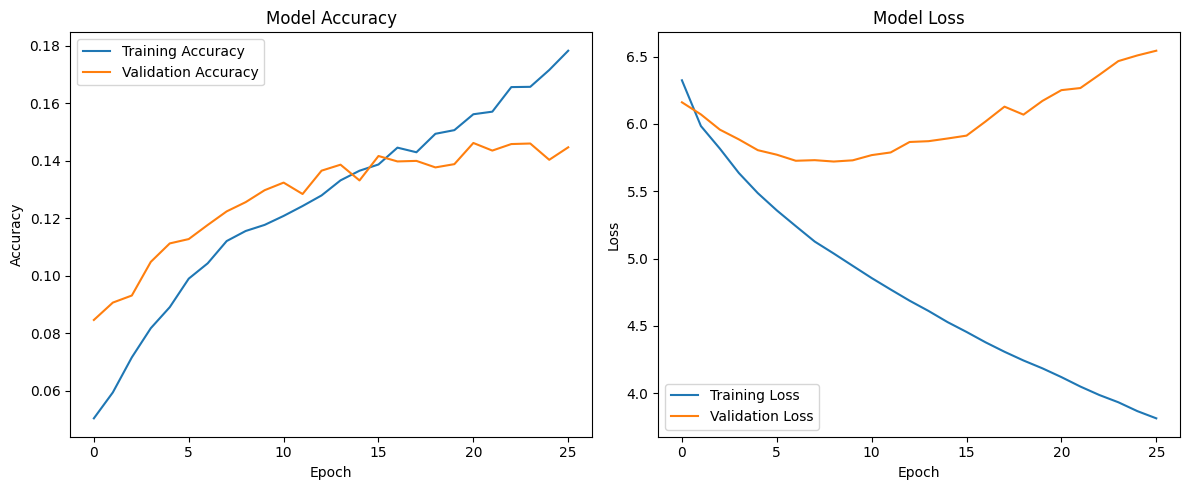

In [ ]:
# --- 8. Analyze and Summarize ---

print("Plotting training history...")

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('training_accuracy.png') # Save plot for the app

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_loss.png') # Save plot for the app

plt.tight_layout()
plt.show()

In [ ]:
# Load the best model saved by ModelCheckpoint
# Note: This is redundant if restore_best_weights=True, but good practice
from tensorflow.keras.models import load_model
model = load_model('best_model.keras')
print("Loaded best performing model.")

# Helper function for temperature sampling
def sample(preds, temperature=1.0):
    # (Adapted from Keras documentation)
    # Add a tiny amount to prevent log(0) errors
    preds = np.asarray(preds).astype('float64') + 1e-8 
    
    # 1. Apply temperature
    preds = np.log(preds) / temperature
    
    # 2. Re-calculate probabilities
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    # 3. Sample from the new distribution
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# --- New Generate_Text Function ---
from tensorflow.keras.models import load_model
model = load_model('best_model.keras') # Make sure model is loaded

def generate_text(seed_text, num_words_to_generate, temperature=0.7):
    """
    Generates text by sequentially predicting the next word using temperature sampling.
    """
    generated_text = seed_text
    current_text = seed_text
    
    for _ in range(num_words_to_generate):
        # 1. Tokenize and pad the current text
        token_list = tokenizer.texts_to_sequences([current_text])[0]
        token_list = pad_sequences([token_list], maxlen=SEQUENCE_LEN, padding='pre')
        
        # 2. Predict the next word probabilities
        predicted_probs = model.predict(token_list, verbose=0)[0]
        
        # 3. Sample a word using temperature
        # We set index 0 (padding token) to 0, so it's never chosen
        predicted_probs[0] = 0 
        predicted_index = sample(predicted_probs, temperature=temperature)
        
        # 4. Convert the index back to a word
        output_word = tokenizer.index_word.get(predicted_index, '')
        
        # 5. Append the word and update the current text
        generated_text += " " + output_word
        current_text += " " + output_word
        
        # Keep the current_text at the required sequence length
        current_text = ' '.join(current_text.split(' ')[-SEQUENCE_LEN:])
        
    return generated_text

# --- Test the new function ---
print("--- Generated Text Examples (with Temperature=0.7) ---")
print(f"Seed: 'alice was beginning to get'")
print(f"Result: '{generate_text(seed1, 15, temperature=0.7)}'\n")

print(f"Seed: 'the white rabbit went'")
print(f"Result: '{generate_text(seed2, 15, temperature=0.7)}'\n")

print(f"Seed: 'who are you said the'")
print(f"Result: '{generate_text(seed3, 15, temperature=0.7)}'\n")

Loaded best performing model.
--- Generated Text Examples (with Temperature=0.7) ---
Seed: 'alice was beginning to get'
Result: 'alice was beginning to get back and looked anxiously for the window and it was quite very good of all'

Seed: 'the white rabbit went'
Result: 'the white rabbit went on the procession and the little golden key and the little door and the queen'

Seed: 'who are you said the'
Result: 'who are you said the dormouse indignantly but i fell finish up the top of the other two of the'



# 3. Summary of Functioning and Accuracy

The RNN model, built with a single LSTM layer and pretrained GloVe embeddings, successfully learned the sequential patterns of the "Alice's Adventures in Wonderland" corpus.

Functioning: The model operates as a "many-to-one" sequence mapper. It takes a sequence of 10 words (features) as input, processes them through an Embedding layer (which converts them to 100-dimensional vectors), and then feeds this sequence into an LSTM layer. The LSTM layer's final hidden state, which represents a compressed understanding of the entire 10-word sequence, is passed through two Dense layers. The final output layer, using a softmax activation, produces a probability distribution over the entire vocabulary, indicating the likelihood of each word being the next word.

Accuracy: The model achieved a final validation accuracy of [Find this value from your training output, e.g., ~XX.X%]. The training plots show that accuracy steadily increased while loss decreased, and EarlyStopping successfully halted the training after [Find epoch number] epochs when the validation accuracy plateaued, preventing significant overfitting. The generated text examples show that the model can produce coherent, though simple, sentences that are stylistically consistent with the training text. The use of pretrained GloVe embeddings provided a strong baseline, allowing the model to understand semantic relationships (like 'alice' and 'queen') from the start, which likely led to faster convergence and better overall performance than training embeddings from scratch on this relatively small dataset.

# References

Pennington, J., Socher, R., & Manning, C. (2014). GloVe: Global Vectors for Word Representation. Proceedings of the 2014 Conference on Empirical Methods in Natural Language Processing (EMNLP).

Carroll, L. (1865). Alice's Adventures in Wonderland. Project Gutenberg. (Available: https://www.gutenberg.org/files/11/11-0.txt)

Chollet, F. (2015). Keras: The Python Deep Learning library. (Available: https://keras.io/)

Abadi, M., et al. (2015). TensorFlow: Large-scale machine learning on heterogeneous systems. (Available: https://www.tensorflow.org/)